In [6]:
import pandas as pd

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(train_df.shape, test_df.shape)
# First, inspect the training data set
train_df.head()
# sibsp: defines family relations in this way...
# Sibling = brother, sister, stepbrother, stepsister
# Spouse = husband, wife (mistresses and fiancés were ignored)

# parch: defines family relations in this way...
# Parent = mother, father
# Child = daughter, son, stepdaughter, stepson
# Some children travelled only with a nanny, therefore parch=0 for them.

# Embarked: from which port



(891, 12) (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Features to use: the rest of the columns such us Passengerid are (probably) irrelevant
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X_train = train_df[features]
y_train = train_df['Survived']
X_test = test_df[features]

In [8]:
# A pipeline is a series of processing and/or modelling steps (data transformers) bundled together into one object
# A comprehensive introduction ot pipeline: https://www.kaggle.com/code/nnjjpp/pipelines-for-preprocessing-a-tutorial (later)
# Preprocessing pipeline
numeric_features = ['Age', 'SibSp', 'Parch', 'Fare']
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # Replace missing values using the mean along each column
    ('scaler', StandardScaler()) # Creates an example of StandardScaler to scale data by removing mean and scaling to unit variance
])

categorical_features = ['Pclass', 'Sex', 'Embarked']
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')), # The mean doesn't make sense here :P
    ('encoder', OneHotEncoder(drop='first')) # As explained, remove the first column to neutralized the multicollinearity
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# ColumnTransformer allows you to apply different transformers (like scalers, encoders, etc.) to different columns
# This line simply calls the numeric_transformer and the categorical_transformer defined above 

In [9]:
from sklearn.linear_model import LogisticRegression

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Pclass', 'Sex',
                                                   'Embarked'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       549
           1       0.77      0.70      0.73       342

    accuracy                           0.81       891
   macro avg       0.80      0.79      0.79       891
weighted avg       0.80      0.81      0.80       891

ROC AUC: 0.8566212891061898


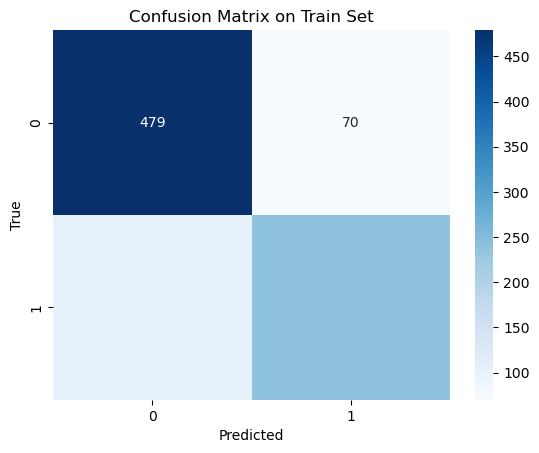

In [11]:
# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_train_pred = model.predict(X_train)
y_train_proba = model.predict_proba(X_train)[:, 1]
# Returns a 2D array where each row corresponds to a sample, and each column corresponds to 
# the probability of that sample belonging to a specific class 
# For binary classification, it will typically have two columns (0, 1) and here we only take the column 1
print(classification_report(y_train, y_train_pred)) # See below: generates a text report showing the main classification metrics 
                                                    # (precision, recall, f1-score) for each class.
print("ROC AUC:", roc_auc_score(y_train, y_train_proba)) # a common metric for binary classifiers, 
                                                         # especially when dealing with imbalanced datasets,
                                                         # meaning one class has significantly more instances than others
# AUC is that it represents the probability that the classifier will rank a randomly chosen positive instance higher than 
# a randomly chosen negative instance
# The AUC is a single scalar value that quantifies the overall performance of a binary classifier across 
# all possible classification thresholds. It is simply the area under the ROC curve.
# The ROC curve is the plot of the true positive rate (TPR) against the false positive rate (FPR) at each threshold setting
# Of course, the threshold designating "positve/negative"
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Train Set')
plt.show() 
# A table used to describe the performance of the model (better than the "accuracy")
#                 Predicted Negative	     Predicted Positive
# True Negative	  True Negatives (TN)	    False Positives (FP)
# True Positive	  False Negatives (FN)	     True Positives (TP)
# From this matriz one can derive: Accuracy, Precision (Positive Predictive Value), Recall (Sensitivity, True Positive Rate),
# Specificity (True Negative Rate), F1-Score
# A well-fitted model should yield a matrix where most of the data occupying the diagonal blocks


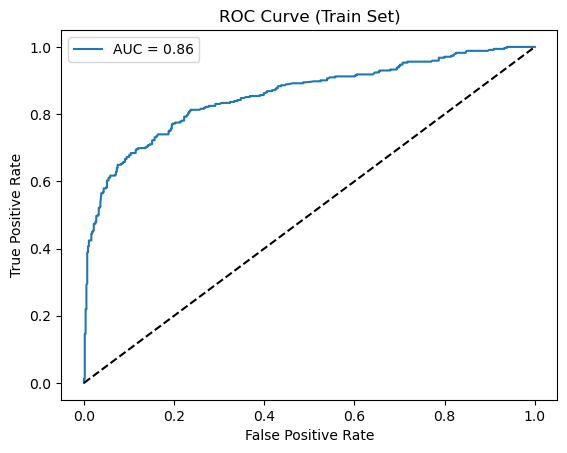

In [12]:
# Visualize the ROC curve
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_train, y_train_proba)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_train, y_train_proba):.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Train Set)')
plt.legend()
plt.show()
# AUC = 0.5: random guessing (the diagonal line) < AUC = 0.86 here :)

In [15]:
# Submission
test_pred = model.predict(X_test)

submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': test_pred
})
submission.to_csv('submission.csv', index=False)
# FIrst submission: Score: 0.77272 (how to improve? Increase the iteration?)